In [13]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=8279ec7faacffb336e630d3aaf7ce07f2f7bf0a96b22ee7cbf034c7c4809835b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=2310e03add1767aed6d7359b4e1aa5f6fa532e1d7858380eae2da9b0268f0faa
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [1]:
!git clone  https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import sys
sys.path.append('/contents/Human-Segmentation-Dataset-mater')

In [3]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

Setup configurations

In [4]:
csv = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'
device = 'cuda'

epochs = 25
learning_rate = 0.003
image_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'


In [5]:
df = pd.read_csv(csv)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


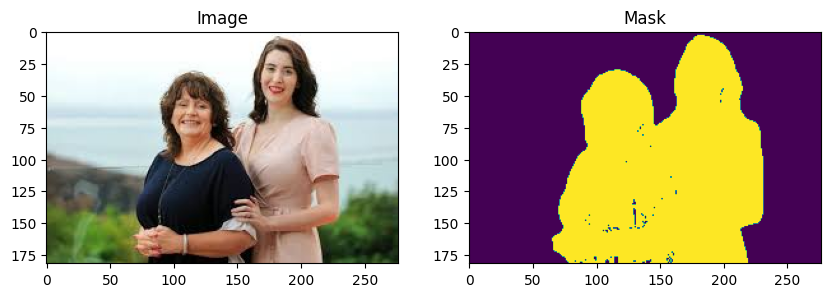

In [6]:
row = df.iloc[34]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.set_title('Image')
ax1.imshow(image)
ax2.set_title('Mask')
ax2.imshow(mask)

In [7]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

                                                 masks  \
84   Human-Segmentation-Dataset-master/Ground_Truth...   
258  Human-Segmentation-Dataset-master/Ground_Truth...   
45   Human-Segmentation-Dataset-master/Ground_Truth...   
175  Human-Segmentation-Dataset-master/Ground_Truth...   
143  Human-Segmentation-Dataset-master/Ground_Truth...   
125  Human-Segmentation-Dataset-master/Ground_Truth...   
224  Human-Segmentation-Dataset-master/Ground_Truth...   
118  Human-Segmentation-Dataset-master/Ground_Truth...   
9    Human-Segmentation-Dataset-master/Ground_Truth...   
90   Human-Segmentation-Dataset-master/Ground_Truth...   
147  Human-Segmentation-Dataset-master/Ground_Truth...   
273  Human-Segmentation-Dataset-master/Ground_Truth...   
33   Human-Segmentation-Dataset-master/Ground_Truth...   
278  Human-Segmentation-Dataset-master/Ground_Truth...   
218  Human-Segmentation-Dataset-master/Ground_Truth...   
77   Human-Segmentation-Dataset-master/Ground_Truth...   
46   Human-Seg

Data Augmentation

In [8]:
import albumentations as A

In [16]:
def train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def val_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
  ])


Creating a custom dataset

In [17]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [19]:
trainset = SegmentationDataset(train_df, train_augs())
validset = SegmentationDataset(test_df, val_augs())

In [20]:
print("The size of the training dataset is: ", len(trainset))
print("The size of the validation dataset is: ", len(validset))

The size of the training dataset is:  232
The size of the validation dataset is:  58


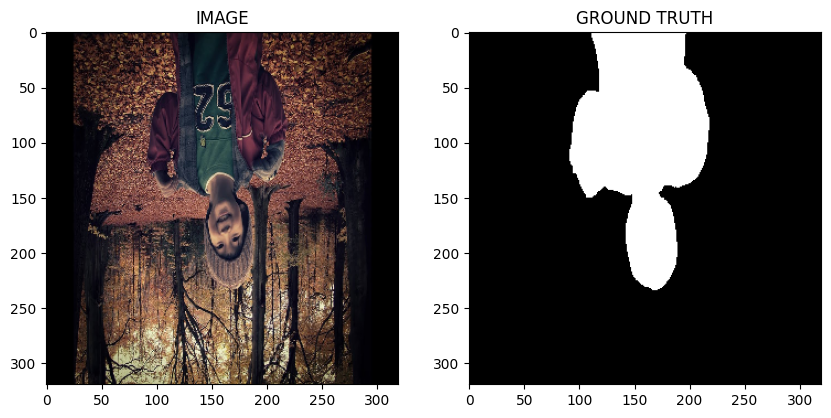

In [22]:
index = 21

image, mask = trainset[index]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0),cmap = 'gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0),cmap = 'gray')

Loading the dataset into batches

In [23]:
from torch.utils.data import DataLoader


In [24]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [25]:
print("The total  number of batches in train loader are: ", len(trainloader))
print("The total  number of batches in valid loader are: ", len(validloader))


The total  number of batches in train loader are:  15
The total  number of batches in valid loader are:  4


Segmentation Model

In [27]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [30]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights= weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [31]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 10.6MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [43]:
def train_function(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)



In [41]:
def validation_function(data_loader, model):
  model.train()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)
      loss.requires_grad = True
      loss.backward()

      total_loss += loss.item()

    return total_loss/len(data_loader)



Model Training

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [44]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss = train_function(trainloader, model, optimizer)
  valid_loss = validation_function(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved")
    best_valid_loss = valid_loss

  print ("Epoch : ", i+1, " , Validation loss : ", valid_loss)

100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Model saved
Epoch :  1  , Validation loss :  0.37763795629143715


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Model saved
Epoch :  2  , Validation loss :  0.3598606139421463


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Epoch :  3  , Validation loss :  0.3990662544965744


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch :  4  , Validation loss :  0.40220022946596146


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Model saved
Epoch :  5  , Validation loss :  0.3297363296151161


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch :  6  , Validation loss :  0.332918643951416


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Model saved
Epoch :  7  , Validation loss :  0.29541992023587227


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Model saved
Epoch :  8  , Validation loss :  0.2904401645064354


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch :  9  , Validation loss :  0.29235289990901947


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Model saved
Epoch :  10  , Validation loss :  0.22815261036157608


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch :  11  , Validation loss :  0.30762508511543274


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch :  12  , Validation loss :  0.3031422309577465


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch :  13  , Validation loss :  0.3791205883026123


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch :  14  , Validation loss :  0.262416023761034


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch :  15  , Validation loss :  0.3165266141295433


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch :  16  , Validation loss :  0.2516109049320221


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch :  17  , Validation loss :  0.33186112344264984


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Epoch :  18  , Validation loss :  0.29864028841257095


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch :  19  , Validation loss :  0.3155478835105896


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch :  20  , Validation loss :  0.25334085524082184


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch :  21  , Validation loss :  0.2783151902258396


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch :  22  , Validation loss :  0.23336749523878098


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Epoch :  23  , Validation loss :  0.30243345722556114


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch :  24  , Validation loss :  0.26876699924468994


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

Epoch :  25  , Validation loss :  0.3356899619102478



Final Inferrence

In [72]:
index = 1

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[index]
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

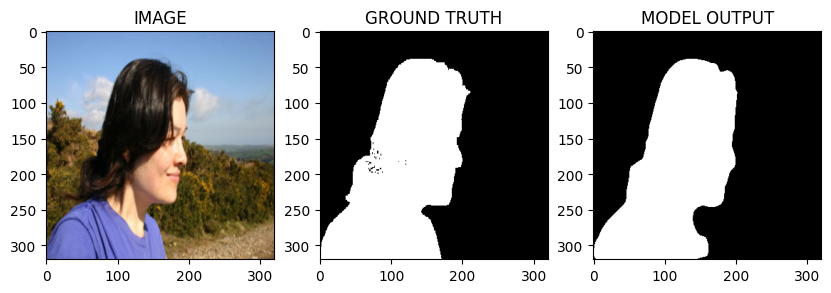

In [73]:


f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
ax3.imshow(pred_mask.detach().cpu().squeeze(0).permute(1,2,0).squeeze(),cmap = 'gray')

In [61]:
helper.show_image(image, mask)

AttributeError: ignored